In [621]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
plt.rcParams['figure.figsize'] = (10.0, 7) 
plt.style.use('seaborn-darkgrid')
font = {'family': 'serif',
         'style': 'italic',
         'weight': 'normal',
        'color':  'black', 
        'size': 13,
        }

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 13

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list
    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'o',color='#40bf40')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = '#66b3ff',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = '#66b3ff', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='#ff6600', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = '#ff6600', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*0.1, max(x)*1.04)
    plt.ylim(min(y)*0.1, max(y)*1.04)
    
    plt.show()

# T Linearly decrease

In [740]:
import math
import random

import matplotlib.pyplot as plt


class SimAnneal(object):
    def __init__(self, coords, T, stopping_T, stopping_iter,Markov):
        self.coords = coords
        self.Markov=Markov
        self.N = len(coords)
        self.T = T if T == -1 else T
#         self.T = 0.01 if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
#         self.alpha =alpha if alpha == -1 else alpha
        self.stopping_temperature = stopping_T if stopping_T == -1 else stopping_T
        self.stopping_iter = stopping_iter if stopping_iter == -1 else stopping_iter
        
        self.alpha =np.power((self.stopping_temperature/self.T),1/(self.stopping_iter-1))
        
        print(self.alpha)
        self.iteration = 1
        self.nodes = [i for i in range(self.N)]
        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []
        self.best_fitness_list=[]
        self.Tlist=[]
        self.prob=[]
        self.meanlist = []
        self.eachtimelist=[]

    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from one random node
        solution = [cur_node]

        free_nodes = set(self.nodes) #let the n nodes become a set 
        free_nodes.remove(cur_node)# remove the initial random node
        
        while free_nodes:#
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            ##find a nearest neighbour
            free_nodes.remove(next_node)
            ##remove this node
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)###calculate the Distance 
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution#the sequence of the nodes
        self.fitness_list.append(cur_fit)
        return solution, cur_fit#total distence

    def dist(self, node_0, node_1):
        """
        Euclidean distance between two nodes.
        """
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

    def fitness(self, solution):
        """
        Total distance of the current solution path.
        """
        cur_fit = 0
        for i in range(self.N):
            cur_fit += self.dist(solution[i % self.N], solution[(i + 1) % self.N])
        return cur_fit

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        candidate_fitness = self.fitness(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
#             self.prob.append(1)
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
                self.prob.append(1)
            
        else:
            random1=random.random()
            k_unknown=self.p_accept(candidate_fitness)
            self.prob.append(k_unknown)
            if random1 < k_unknown:
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate
    
    def T_change(self):
        self.T *= self.alpha
        
    def get_cur(self):
        return np.mean(self.meanlist,axis=0),np.std(self.meanlist,axis=0)
        
    def markovchange(self):
        for mark in range(self.Markov):
            candidate = list(self.cur_solution)
            l = random.randint(2, self.N - 1) #create the integer between 2 and self.N - 1
            i = random.randint(0, self.N - l)#create the integer between 0 and self.N - 1
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])#reverse the candidate one
            # this step is actually a random way
            self.accept(candidate)
        

    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution() 
        self.eacheach=[]
        hi=[]
#         print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            #evalue if it is better solution
            self.markovchange()

            self.T_change()# the rate of annealing
            self.Tlist.append(self.T)
            self.iteration += 1
            self.fitness_list.append(self.cur_fitness)
            hi.append(self.cur_fitness)
            
        self.meanlist.append(hi)
        self.best_fitness_list.append(self.best_fitness)
#         print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
#         print(f"Improvement over greedy heuristic: {improvement : .2f}%")

    def batch_anneal(self, times):
        """
        Execute simulated annealing algorithm `times` times, with random initial solutions.
        """
        times=times
        for i in range(1, times + 1):
#             print(f"Iteration {i}/{times} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
#             self.cur_solution, self.cur_fitness = self.initial_solution()
            self.anneal()
            self.eachtimelist.append(self.meanlist)
            
            
            
    def print_result(self):
        
        return self.fitness_list
    
    def visualize_routes(self):
        """
        Visualize the TSP route with matplotlib.
        """
        plotTSP([self.best_solution], self.coords)
        plt.savefig('initialsolution1.jpg')

    def plot_learning(self):
        """
        Plot the fitness through iterations.
        """
        
        print('Best:',self.best_fitness_list[-1])
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list,color='#ff6600')
        
        plt.ylabel("Distance",font)
        plt.xlabel("Steps",font)
        plt.savefig('initialsolutioncurve.jpg')
#         plt.legend()
        plt.show()
    
    def plot_T(self):
        plt.plot([i for i in range(len(self.Tlist))], self.Tlist,color='#ff6600')
#         plt.xscale("log")
        plt.ylabel("Temperature",font)
        plt.xlabel("Steps",font)
#         plt.legend()
        plt.show()
        
    
    def plot_best(self):
        """
        Plot the fitness through iterations.
        """
        plt.plot([i for i in range(len(self.best_fitness_list))], self.best_fitness_list)
        print('Best:',self.best_fitness_list[-1])
        plt.ylabel("Best Fitness",font)
        plt.xlabel("Iteration",font)
        plt.show()
        
#     def plt_prob(self):
#         plt.scatter([i for i in range(len(self.prob))], self.prob,s=2, c='#0099ff')
#         plt.ylabel("Accept Probability",font)
#         plt.xlabel("Iteration",font)
#         plt.show()

        
    def get_mean_variance(self):
        haha = np.mean(self.meanlist,axis=0)
        hahastd = np.std(self.meanlist,axis=0)
        return haha,hahastd
        
    def plot_mean(self):
        haha = np.mean(self.meanlist,axis=0)
        hahastd = np.std(self.meanlist,axis=0)
        
        Lh1list=[]
        Lh2list=[]        
        # Find the minimum and maximum values of the mean waiting time (to show error bar)
        for j in range(len(haha)):
            Lh1list.append(haha[j] + hahastd[j])
            Lh2list.append(haha[j] - hahastd[j])

        plt.plot(np.arange(0,len(haha),1),haha)
        plt.xlabel('Steps')
        plt.ylabel('Distance')
        plt.fill_between(np.arange(0,len(haha),1),Lh1list,Lh2list, alpha=0.2, edgecolor="white")
        plt.show()
        

0.9988490823726969


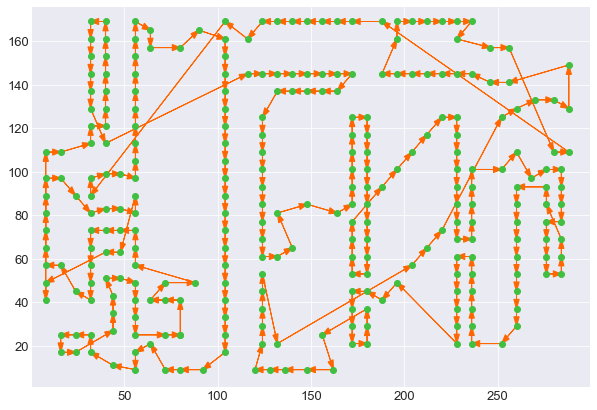

In [623]:
z22222=SimAnneal(city1,10, 0.1,4000 ,10)
z22222.initial_solution()
z22222.visualize_routes()

#  Convergence to a local or maybe the Global minimum

# 280

In [219]:
a1 = np.loadtxt('a280.tsp.txt')
city1=np.delete(a1,0,1)

0.999232638265672


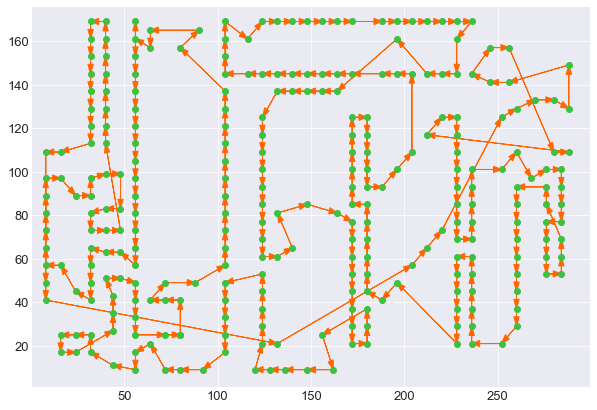

<Figure size 720x504 with 0 Axes>

In [733]:
z2=SimAnneal(city1,10, 0.1,6000 ,50)
z2.initial_solution()
z2.visualize_routes()
z2.batch_anneal(1)
#2586.76964756

Best: 2910.7668376370148


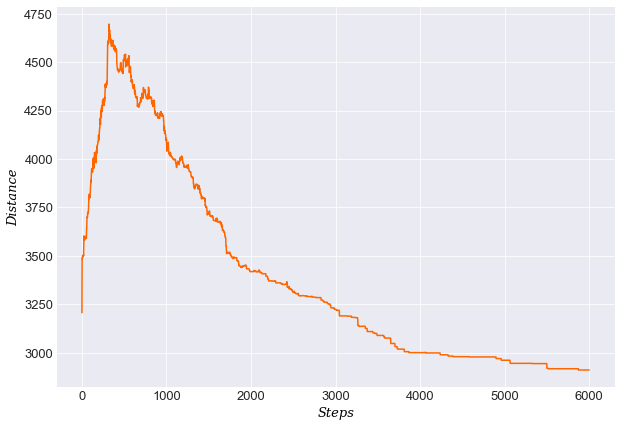

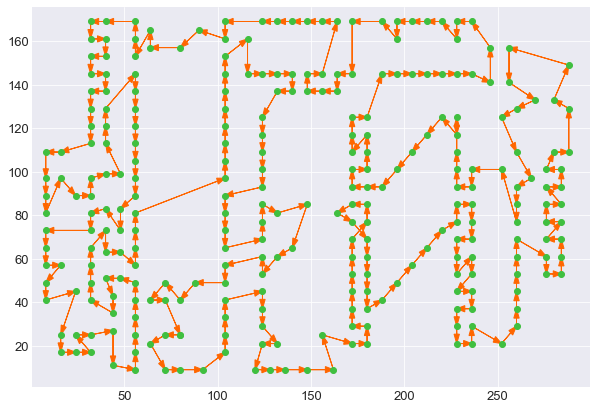

<Figure size 720x504 with 0 Axes>

In [735]:
z2.plot_learning()
z2.visualize_routes()

#2696.876875003953 200
#2655.4238210525905 300

# Changing the Initial temperature

In [741]:
class Tchangeinitial_SimAnneal(SimAnneal):
    def __init__(self, coords, T, stopping_T, alpha, stopping_iter,Markov):
        
        self.coords = coords
        self.Markov=Markov
        self.N = len(coords)
        self.T = T 
#         self.T = 0.01 if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
#         self.alpha =alpha if alpha == -1 else alpha
        self.stopping_temperature = stopping_T 
        self.stopping_iter = stopping_iter 
        
        self.alpha =alpha
        print(alpha)
        self.iteration = 1
        self.nodes = [i for i in range(self.N)]
        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []
        self.best_fitness_list=[]
        self.Tlist=[]
        self.prob=[]
        self.meanlist = []
        self.eachtimelist=[]
    
    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        # Initialize with the greedy solution.
        self.cur_solution, self.cur_fitness = self.initial_solution() 
        self.eacheach=[]
        hi=[]
#         print("Starting annealing.")
        while self.T >= self.stopping_temperature:
            #evalue if it is better solution
            self.markovchange()

            self.T_change()# the rate of annealing
            self.Tlist.append(self.T)
            self.iteration += 1
            self.fitness_list.append(self.cur_fitness)
            hi.append(self.cur_fitness)
            
        self.meanlist.append(hi)
        self.best_fitness_list.append(self.best_fitness)
#         print("Best fitness obtained: ", self.best_fitness)
        improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])


In [390]:
#last value's mean and std

tinitial=[0.1,1,10,20,50]#,10,15,20
hmeanlist=[]
hvariancelist=[]
for i in tinitial:
    tem1=Tchangeinitial_SimAnneal(city1,i, 1e-5,0.995, 100000000,50)
    tem1.initial_solution()
    tem1.batch_anneal(50)
    q11,q22=tem1.get_mean_variance()
    hmeanlist.append(q11)
    hvariancelist.append(q22)


0.995
0.995
0.995
0.995
0.995


In [400]:
label=['0.1','1','10','20','50']
for k in range(0):
    Lh1list=[]
    Lh2list=[]
    for j in range(len(hmeanlist[k])):
        Lh1list.append(hmeanlist[k][j] + hvariancelist[k][j])
        Lh2list.append(hmeanlist[k][j] - hvariancelist[k][j])

    plt.plot(np.arange(0,len(hmeanlist[k]),1),hmeanlist[k],label=label[k])
    plt.xlabel('Steps')
    plt.ylabel('Distance')
    plt.fill_between(np.arange(0,len(hmeanlist[k]),1),Lh1list,Lh2list, alpha=0.2, edgecolor="white")

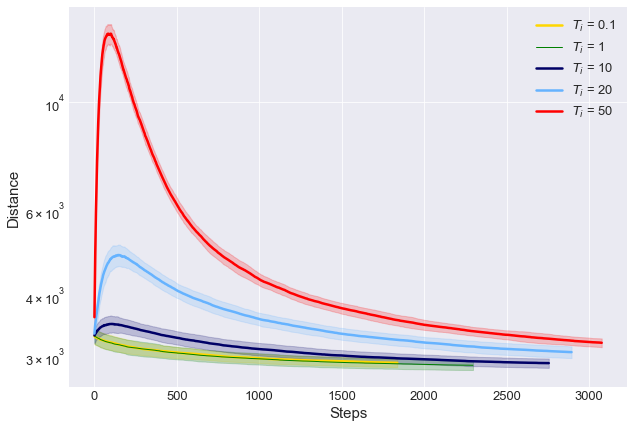

In [624]:
label=[r'$T_i$ = 0.1',r'$T_i$ = 1',r'$T_i$ = 10',r'$T_i$ = 20',r'$T_i$ = 50']
color=['#ffd700','#008000','#000066','#66b3ff','#ff0000']
for k in range(len(hmeanlist)):
    Lh1list=[]
    Lh2list=[]
    for j in range(len(hmeanlist[k])):
        Lh1list.append(hmeanlist[k][j] + hvariancelist[k][j])
        Lh2list.append(hmeanlist[k][j] - hvariancelist[k][j])
    if k==1:
        linestyle='-'
        linewidth=1
    else:
        linestyle='-'
        linewidth=2.5
    plt.plot(np.arange(0,len(hmeanlist[k]),1),hmeanlist[k],linestyle,linewidth=linewidth,label=label[k],color=color[k])
    plt.xlabel('Steps',size=15)
    plt.ylabel('Distance',size=15)
    plt.fill_between(np.arange(0,len(hmeanlist[k]),1),Lh1list,Lh2list, color=color[k],alpha=0.2, edgecolor="white")


plt.yscale('log')
# plt.ylim([2000,5000])
plt.legend()
plt.savefig('initialtime.jpg')

In [395]:
hmeanlist[k][-1]

3192.03410343813

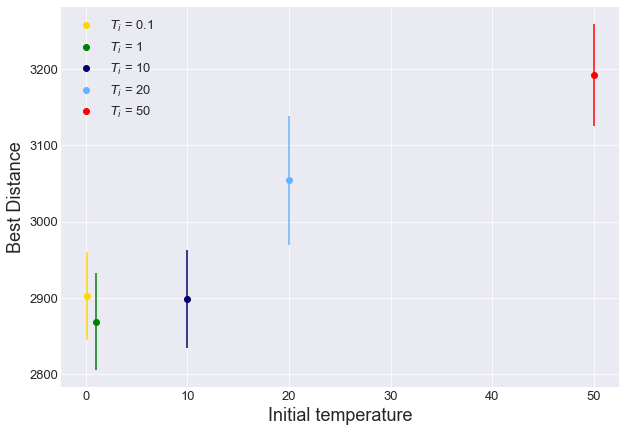

In [696]:

for k in range(len(hmeanlist)):
    plt.plot(tinitial[k],hmeanlist[k][-1],'o',label=label[k],color=color[k])
    plt.errorbar(tinitial[k],hmeanlist[k][-1],yerr=hvariancelist[k][-1],color=color[k])
plt.xlabel('Initial temperature',size=18)
plt.ylabel('Best Distance',size=18)
plt.legend()
plt.savefig('initialtime_error.jpg')

# Changing the end temperature

In [518]:
#same 0.1,0.01,0.001,0.0001,0.00001
tend=[0.1,1e-2,1e-3,1e-4,1e-5]#,20,np.sqrt(280)

h1meanlist=[]
h1variancelist=[]
for i in tend:
    con2=Tchangeinitial_SimAnneal(city1 ,10, i ,0.995, 100000000,50)
    con2.initial_solution()
    con2.batch_anneal(50)
    a11,a22=con2.get_mean_variance()
    h1meanlist.append(a11)
    h1variancelist.append(a22)


0.995
0.995
0.995
0.995
0.995


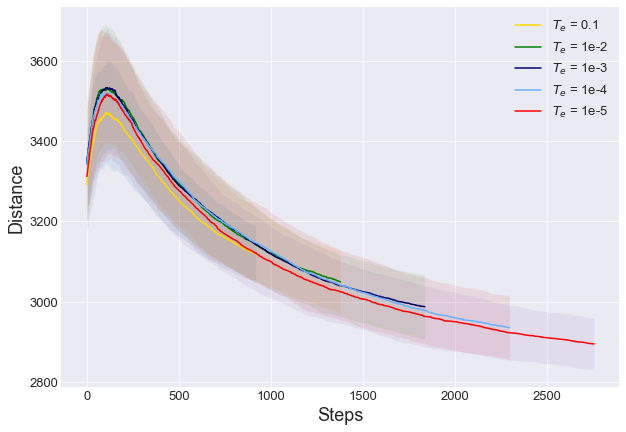

In [697]:
label1=[r'$T_e$ = 0.1',r'$T_e$ = 1e-2',r'$T_e$ = 1e-3',r'$T_e$ = 1e-4',r'$T_e$ = 1e-5']
for k in range(len(h1meanlist)):
    Lh1list=[]
    Lh2list=[]
    for j in range(len(h1meanlist[k])):
        Lh1list.append(h1meanlist[k][j] + h1variancelist[k][j])
        Lh2list.append(h1meanlist[k][j] - h1variancelist[k][j])
    plt.plot(np.arange(0,len(h1meanlist[k]),1),h1meanlist[k],label=label1[k],color=color[k])
    plt.xlabel('Steps',size=18)
    plt.ylabel('Distance',size=18)
    plt.fill_between(np.arange(0,len(h1meanlist[k]),1),Lh1list,Lh2list, alpha=0.1, edgecolor="white")
    
plt.legend()
plt.savefig('endtime.jpg')
# plt.yscale('log')

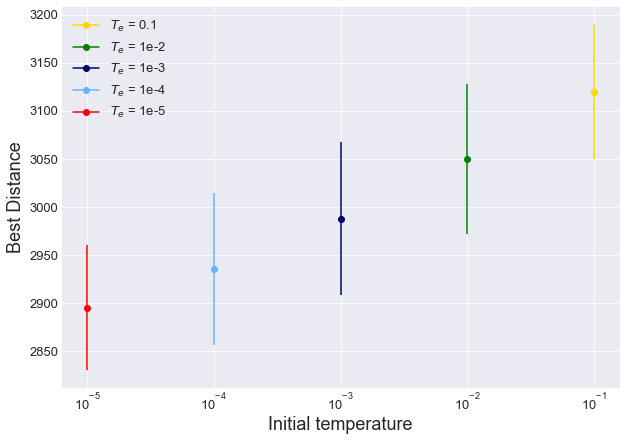

In [698]:

for k in range(len(h1meanlist)):
    plt.plot(tend[k],h1meanlist[k][-1],'o-',label=label1[k],color=color[k])
    plt.errorbar(tend[k],h1meanlist[k][-1],yerr=h1variancelist[k][-1],color=color[k])
plt.xlabel('Initial temperature',size=18)
plt.xscale('log')
plt.ylabel('Best Distance',size=18)
plt.legend(loc=2)
plt.savefig('endtime_error.jpg')

# Changing the rule of temperature

alpha linear: 0.0033333300000000002
alpha exponential:  0.995405417351527
alpha quad:  0.11111099999999999


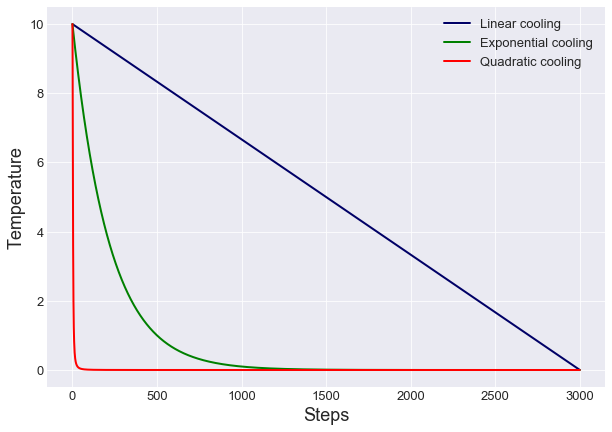

In [700]:
Ti = 10.
Tf = 1e-5
total_steps = 3000

# Calculate the alpha for different methods using fixed conditions
alpha_lin = (Ti - Tf) / total_steps
print('alpha linear:', alpha_lin)

alpha_exp = np.power((Tf / Ti), (1 / total_steps))
print('alpha exponential: ',alpha_exp)

alpha_quad = (((Ti / Tf) - 1) / np.power(total_steps,2))
print('alpha quad: ',alpha_quad)

linear = []
exponential = []
quadratic = []

# Calculate the temperature decrease for exponential and quadratic cooling
for i in range(total_steps):    
    exponential.append(Ti * np.power(alpha_exp,i))
    quadratic.append(Ti / (1 + alpha_quad * i * i))    

# Temperature decrease for linear cooling
for i in range(total_steps):
    linear.append(Ti)
    Ti = Ti - alpha_lin

# Plot the temperature decrease for the three methods
plt.plot(np.arange(0,total_steps,1),linear,label='Linear cooling',color=color[2],linewidth=2)
plt.plot(np.arange(0,total_steps,1),exponential,label='Exponential cooling',color=color[1],linewidth=2)
plt.plot(np.arange(0,total_steps,1),quadratic,label='Quadratic cooling',color=color[4],linewidth=2)
plt.xlabel('Steps',size=18)
plt.ylabel('Temperature',size=18)
# plt.xscale('log')
plt.legend(loc=1)
plt.savefig('coolingschedules.png',dpi=600) # Save figure
plt.show()

In [652]:
e11=SimAnneal(city1,10, 1e-5,3000 ,50)
e11.initial_solution()
e11.batch_anneal(50)
e111,e222=e11.get_mean_variance()

0.9954038888394124


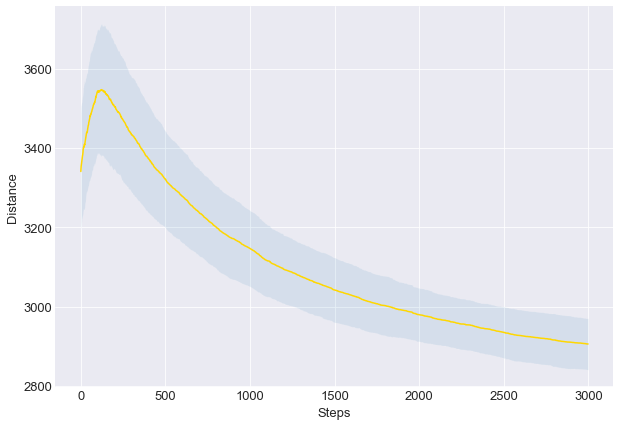

In [655]:
Lh9list=[]
Lh10list=[]
for j in range(len(e111)):
    Lh9list.append(e111[j] + e222[j])
    Lh10list.append(e111[j] - e222[j])
plt.plot(np.arange(0,len(e111),1),e111,label=label1[0],color=color[0])
plt.xlabel('Steps')
plt.ylabel('Distance')
plt.fill_between(np.arange(0,len(e111),1),Lh9list,Lh10list, alpha=0.1, edgecolor="white")

Quadratic multiplicative cooling 

In [640]:
#Quadratic multiplicative cooling 

class quaSimAnneal(SimAnneal):
     def __init__(self, coords, T, stopping_T,alpha, stopping_iter,Markov):
        self.coords = coords
        self.Markov=Markov
        self.N = len(coords)
        self.T = T if T == -1 else T
#         self.T = 0.01 if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
#         self.alpha =alpha if alpha == -1 else alpha
        self.stopping_temperature = stopping_T if stopping_T == -1 else stopping_T
        self.stopping_iter = stopping_iter if stopping_iter == -1 else stopping_iter
        
        self.alpha =alpha
        
        print(self.alpha)
        self.iteration = 1
        self.nodes = [i for i in range(self.N)]
        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []
        self.best_fitness_list=[]
        self.Tlist=[]
        self.prob=[]
        self.meanlist = []
        self.eachtimelist=[]

    
     def T_change(self):
        self.T =self.T_save/(1+self.alpha*(self.iteration)**2)
        

In [657]:
alpha_quad = (((10 / 1e-5) - 1) / np.power(3000,2))
print('alpha quad: ',alpha_quad)

alpha quad:  0.11111099999999999


In [658]:
#,20,np.sqrt(280)

q2=quaSimAnneal(city1 ,10, 1e-5 ,alpha_quad, 1000000,50)
q2.initial_solution()
q2.batch_anneal(50)
q111,q222=q2.get_mean_variance()

0.11111099999999999


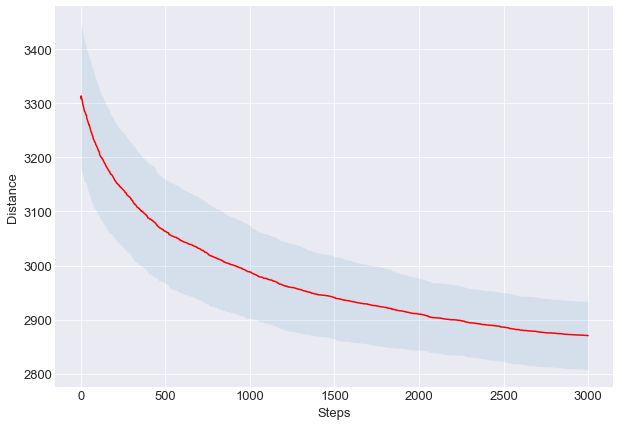

In [659]:
Lh6list=[]
Lh7list=[]
for j in range(len(q111)):
    Lh6list.append(q111[j] + q222[j])
    Lh7list.append(q111[j] - q222[j])
plt.plot(np.arange(0,len(q111),1),q111,label=label1[k],color=color[k])
plt.xlabel('Steps')
plt.ylabel('Distance')
plt.fill_between(np.arange(0,len(q111),1),Lh6list,Lh7list, alpha=0.1, edgecolor="white")

# linear

In [736]:
class linSimAnneal(SimAnneal):
     def __init__(self, coords, T, stopping_T,alpha, stopping_iter,Markov):
        self.coords = coords
        self.Markov=Markov
        self.N = len(coords)
        self.T = T if T == -1 else T
#         self.T = 0.01 if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
#         self.alpha =alpha if alpha == -1 else alpha
        self.stopping_temperature = stopping_T if stopping_T == -1 else stopping_T
        self.stopping_iter = stopping_iter if stopping_iter == -1 else stopping_iter
        
        self.alpha =alpha
        
        print(self.alpha)
        self.iteration = 1
        self.nodes = [i for i in range(self.N)]
        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []
        self.best_fitness_list=[]
        self.Tlist=[]
        self.prob=[]
        self.meanlist = []
        self.eachtimelist=[]

    
     def T_change(self):
        self.T = self.T-self.alpha
        

In [662]:
alpha_lin = (10 - 1e-5) / 3000
print('alpha linear:', alpha_lin)

alpha linear: 0.0033333300000000002


In [663]:
lin1=linSimAnneal(city1 ,10, 1e-5 ,alpha_lin, 1000000,50)
lin1.initial_solution()
lin1.batch_anneal(50)
lin111,lin222=lin1.get_mean_variance()

0.0033333300000000002


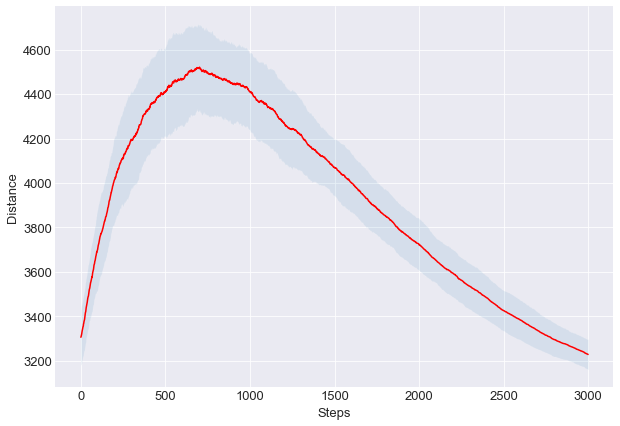

In [664]:
Lin1list=[]
Lin2list=[]
for j in range(len(lin111)):
    Lin1list.append(lin111[j] + lin222[j])
    Lin2list.append(lin111[j] - lin222[j])
plt.plot(np.arange(0,len(lin111),1),lin111,label=label1[k],color=color[k])
plt.xlabel('Steps')
plt.ylabel('Distance')
plt.fill_between(np.arange(0,len(lin111),1),Lin1list,Lin2list, alpha=0.1, edgecolor="white")

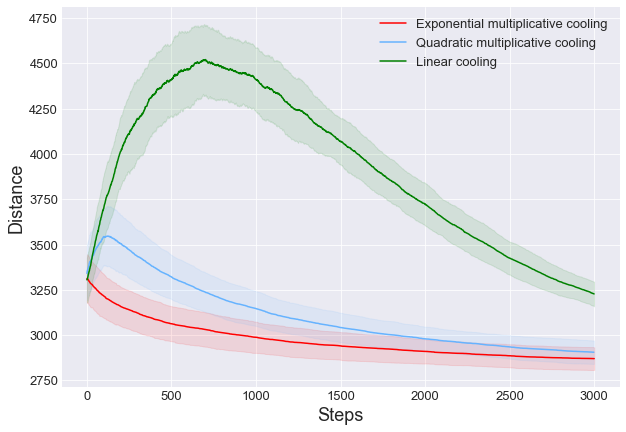

In [701]:
plt.plot(np.arange(0,len(q111),1),q111,label='Exponential multiplicative cooling',color=color[4])
plt.fill_between(np.arange(0,len(q111),1),Lh6list,Lh7list, alpha=0.1, color=color[4],edgecolor="white")

plt.plot(np.arange(0,len(e111),1),e111,label='Quadratic multiplicative cooling',color=color[3])
plt.fill_between(np.arange(0,len(e111),1),Lh9list,Lh10list, alpha=0.1,color=color[3], edgecolor="white")

plt.plot(np.arange(0,len(lin111),1),lin111,label='Linear cooling',color=color[1])
plt.fill_between(np.arange(0,len(lin111),1),Lin1list,Lin2list, alpha=0.1, edgecolor="white",color=color[1])

plt.legend()
plt.xlabel('Steps',size=18)
plt.ylabel('Distance',size=18)
plt.savefig('Differentmethod.jpg')

# Changing markov chains

In [418]:
markov=[1,10,30,50,70]#,10,15,20
h2meanlist=[]
h2variancelist=[]
for i in markov:
    tem3=Tchangeinitial_SimAnneal(city1,10, 1e-5,0.995, 100000000,i)
    tem3.initial_solution()
    tem3.batch_anneal(50)
    d11,d22=tem3.get_mean_variance()
    h2meanlist.append(d11)
    h2variancelist.append(d22)

0.995
0.995
0.995
0.995
0.995


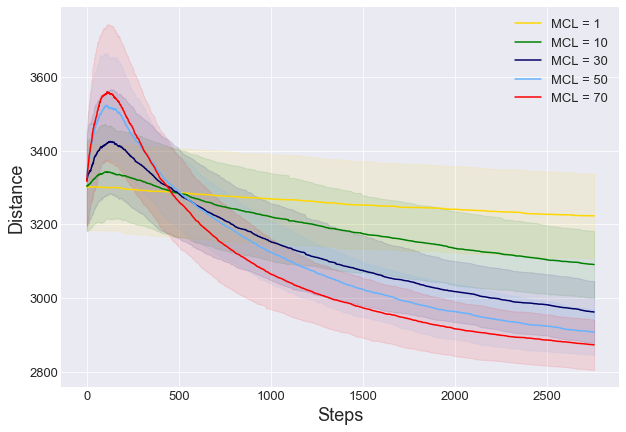

In [702]:
label4=['MCL = 1','MCL = 10','MCL = 30','MCL = 50','MCL = 70']

for k in range(len(h2meanlist)):
    Lh1list=[]
    Lh2list=[]
    for j in range(len(h2meanlist[k])):
        Lh1list.append(h2meanlist[k][j] + h2variancelist[k][j])
        Lh2list.append(h2meanlist[k][j] - h2variancelist[k][j])
    plt.plot(np.arange(0,len(h2meanlist[k]),1),h2meanlist[k],label=label4[k],color=color[k])
    plt.xlabel('Steps',size=18)
    plt.ylabel('Distance',size=18)
    plt.fill_between(np.arange(0,len(h2meanlist[k]),1),Lh1list,Lh2list, alpha=0.1, color=color[k],edgecolor="white")
    
plt.legend()
plt.savefig('markov.jpg')


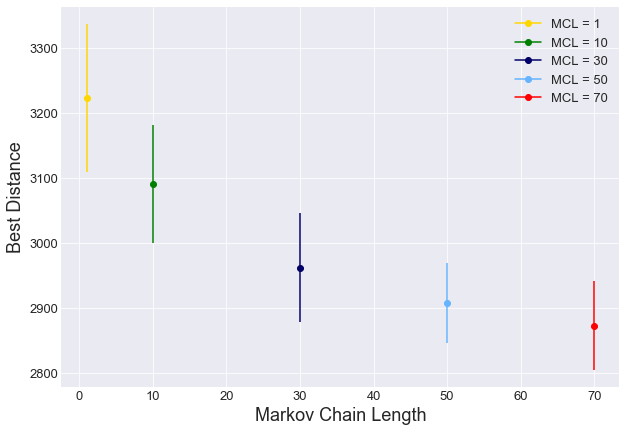

In [703]:

for k in range(len(h2meanlist)):
    plt.plot(markov[k],h2meanlist[k][-1],'o-',label=label4[k],color=color[k])
    plt.errorbar(markov[k],h2meanlist[k][-1],yerr=h2variancelist[k][-1],color=color[k])
plt.xlabel('Markov Chain Length',size=18)
# plt.xscale('log')
plt.ylabel('Best Distance',size=18)
plt.legend(loc=1)
plt.savefig('markov_error.jpg')

# Changing alpha

In [704]:
alphalist=[0.5,0.9,0.95,0.995,0.9995]#,10,15,20
almeanlist=[]
alvariancelist=[]
for i in alphalist:
    alpha3=Tchangeinitial_SimAnneal(city1,10, 1e-5,i, 100000000,50)
    alpha3.initial_solution()
    alpha3.batch_anneal(50)
    al11,al22=alpha3.get_mean_variance()
    almeanlist.append(al11)
    alvariancelist.append(al22)

0.5
0.9
0.95
0.995
0.9995


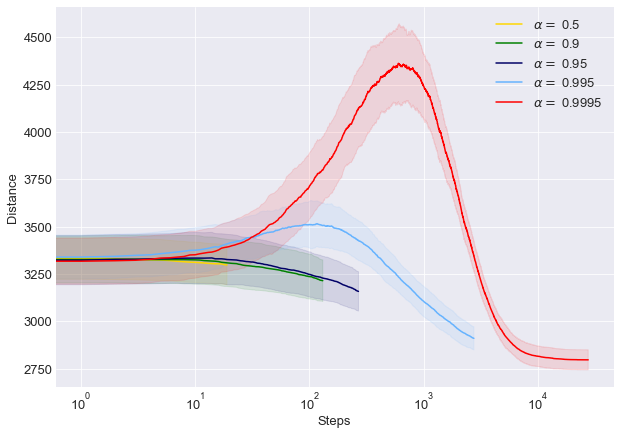

In [722]:
label5=[r'$\alpha =$ 0.5',r'$\alpha =$ 0.9',r'$\alpha =$ 0.95',r'$\alpha =$ 0.995', r'$\alpha =$ 0.9995']

for k in range(len(almeanlist)):
    Lh1list=[]
    Lh2list=[]
    for j in range(len(almeanlist[k])):
        Lh1list.append(almeanlist[k][j] + alvariancelist[k][j])
        Lh2list.append(almeanlist[k][j] - alvariancelist[k][j])
    plt.plot(np.arange(0,len(almeanlist[k]),1),almeanlist[k],label=label5[k],color=color[k])
    plt.xlabel('Steps')
    plt.ylabel('Distance')
    plt.fill_between(np.arange(0,len(almeanlist[k]),1),Lh1list,Lh2list, alpha=0.1, color=color[k],edgecolor="white")
    
plt.legend()
plt.xscale('log')
# plt.savefig('alpha.jpg')
# plt.yscale('log')

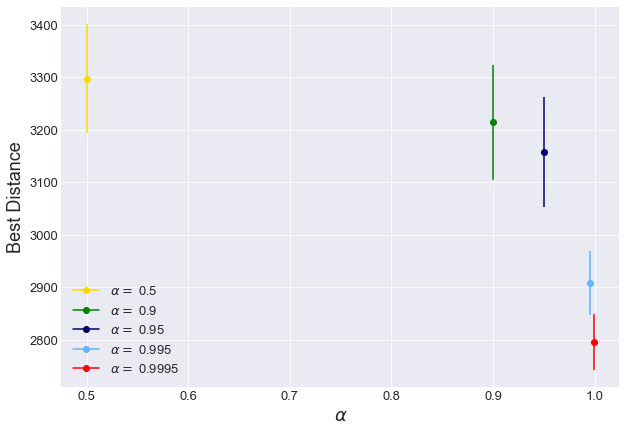

In [748]:
for k in range(len(almeanlist)):
    plt.plot(alphalist[k],almeanlist[k][-1],'o-',label=label5[k],color=color[k])
    plt.errorbar(alphalist[k],almeanlist[k][-1],yerr=alvariancelist[k][-1],color=color[k])
plt.xlabel(r'$\alpha$',size=18)
# plt.xscale('log')
plt.ylabel('Best Distance',size=18)
plt.legend(loc=3)
plt.savefig('alpha_error.jpg')

# Final

0.9995


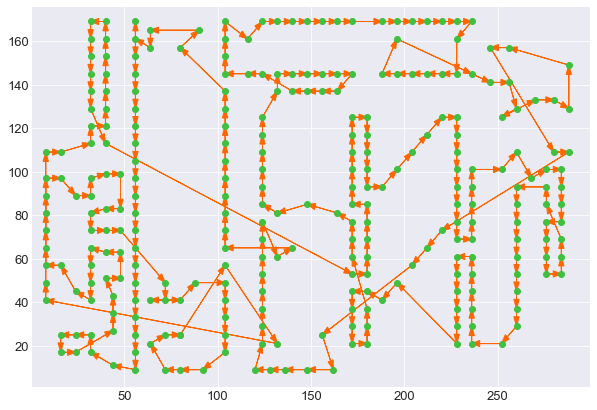

<Figure size 720x504 with 0 Axes>

In [745]:
best1=Tchangeinitial_SimAnneal(city1,10, 1e-5,0.9995, 100000000,70)
best1.initial_solution()
best1.visualize_routes()
best1.batch_anneal(1)

Best: 2793.242488366303


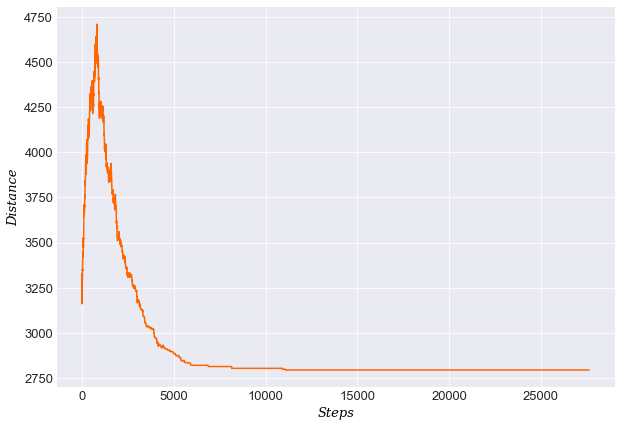

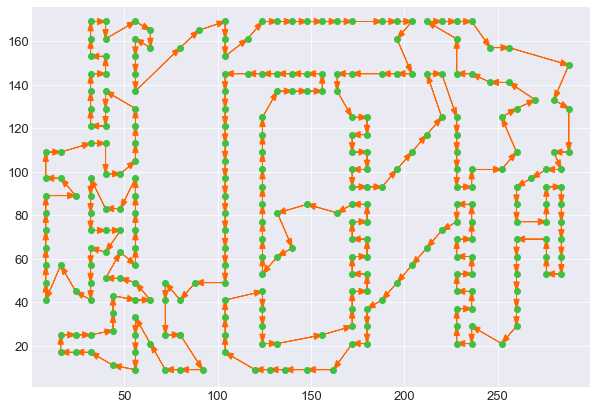

<Figure size 720x504 with 0 Axes>

In [746]:
best1.plot_learning()

best1.visualize_routes()

# # Calculate the optimal distance

In [ ]:
# The file containing all the cities
file = np.loadtxt('a280.tsp.txt')
# file = np.loadtxt('eil51.tsp.txt')
cities = np.delete(file,0,1)

# This file contains the optimal tour
opt_dist = np.loadtxt('a280.opt.tour.txt')
# opt_dist = np.loadtxt('eil51.opt.tour.txt')

def calculate_opt_distance(cities,opt_path):
    """
    Calculate the optimal distance using the opt file
    """
    distance = 0
    
    for i in range(int(len(opt_path)  - 2)):
        distance += dist1(cities[int(opt_path[i])-1], cities[int(opt_path[i+1])-1])

    distance += dist1(cities[int(opt_path[0])-1], cities[int(opt_path[i+1])-1])

    print('Optimal distance: ',distance)
    plt.show()
    return distance

def dist1(node_0, node_1):
    """
    Euclidean distance between two nodes.
    """
    plt.plot([node_0[0],node_1[0]],[node_0[1] ,node_1[1]], 'o-',color='Black')
    return math.sqrt((node_0[0] - node_1[0]) ** 2 + (node_0[1] - node_1[1]) ** 2)

best_distance = calculate_opt_distance(cities,opt_dist)


# Alpha and Markov chain comparison

In [ ]:
# Keep total steps count the same
init_t = 10
final_t = 1e-8

alpha_list = np.arange(0.29,1.0,0.01)
markov_chains = [] # np.arange(min_mc,max_mc,interval_mc)
iterations = [] # np.arange(min_iter,max_iter,interval_iter)
print('Alpha: ',alpha_list)
total_steps = 20000

for alpha in alpha_list:
    iter_count = np.log(final_t/init_t) / np.log(alpha)
    iterations.append(iter_count)
    markov_chains.append(int(round(total_steps / iter_count)))

print('Iterations:',iterations)
print('Markov chains:',markov_chains)

all_results_final = []
all_results_final_std = []

# Calculate the distance for different alphas
for idx,iters in enumerate(iterations):
      
    z=SimAnneal(city,init_t,final_t,iters,markov_chains[idx])
    print('values:',iters,markov_chains[idx])
    z.batch_anneal(50)

    # Get the best value
    mean,std = z.get_cur()
    all_results_final.append(mean)
    all_results_final_std.append(std)
    
    print('Total steps:',len(mean))

In [ ]:
# Calculate the top and bottom error margins
top = []
bottom = []

for idx,i in enumerate(all_results_final_std):
    top.append(all_results_final[idx][-1] + i[-1])
    bottom.append(all_results_final[idx][-1] - i[-1])

# Plot the mean distance with the standard deviations -- alpha on x-axis
plt.fill_between(np.arange(0.29,1.,0.01),top,bottom,alpha=0.1,edgecolor='white',color='red')
plt.plot(np.arange(0.29,1.,0.01),[i[-1] for i in all_results_final],color='red')
plt.xlabel(r'$\alpha$')
plt.ylabel('Distance')
# plt.savefig('constant_steps_different_alpha_and_mcl_3.png',dpi=500)
plt.show()

# Plot the mean distance with the standard deviations -- Markov Chain Length on x-axis
alpha_list = np.arange(0.29,1.,0.01)
markov_chains = [] 
total_steps = 20000

for alpha in alpha_list:
    iter_count = np.log(1e-8 / 10) / np.log(alpha)
    markov_chains.append(int(round(total_steps / iter_count)))

plt.fill_between(markov_chains,top,bottom,alpha=0.5)
plt.plot(np.arange(0.29,1.,0.01),[i[-1] for i in all_results_final])
plt.xlabel('Markov Chain Length')
plt.ylabel('Distance')
# plt.savefig('constant_steps_different_alpha_and_mcl.png',dpi=500)
plt.show()